<h1><center> Model Architectures for Semantic Segmentation</h1></center>

In a nutshell, there are two types of architectures that are prominent in semantic segmentation.

<h2><center>Encoder Decoder Based Architecture</center></h2>

**Encoder**: A pre-trained classification network like VGG/ResNet followed by a decoder network. 

**Decoder**: The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. This is where most architectures differ. Some architectures directly upsample the feature map and some use complex architecture to get more refined outputs. 


We are going to see some common examples of encoder-decoder type of architectures

<h3>1) Fully Convolutional Network</h3>

This idea was developed in late 2014 and the approach was to use a fully convolutional network for the task of segmenting objects into various categories. The paper's authors proposed to adapt the then existing networks used for image classification task such as AlexNet which served as encoder of the network which decreases the spatial resolution of the input image. This was later joined by a decoder module with transpose convolutional layers to upsample the feature maps into a full-resolution segmentation map.

<img src="img/fcn.png">

They also used **skip connections** to refine the coarse feature map since the raw upsampled feature map gave
very bad results


<img src="img/fcn2.png">
SOURCE: Overview of semantic segmentation: Jeremy Jordan


<h3>2) ERFNet: Efficient Residual Factorized ConvNet for Semantic Segmentation</h3>

<img src="img/erfnet.png">
<img src="img/erfnet-model.png">


<img src="img/erfnet-module.png">


We show two ways to train the **ERFNET architecture** on a standard dataset:

-  Training the encoder and decoder from the scratch.
-  Just training the encoder and then bilinearly upsampling the encoder's output to match input image size .

ERFNET reformulates the **Resnet architecture** into novel 1-d bottleneck and non bottleneck 1-d blocks (See more in the paper). Because of the ResNet architecture, the information of semantic boundary is passed through the residual mappings and hence the need for explicit skip connections is not required.   

Downsampling (reducing the spatial resolution) has the drawback of reducing the accuracy (coarser outputs), but it
also  has  two  benefits:  it  lets  the  deeper  layers  gather  more context  (to  improve  classification)  and  it  helps  to  reduce computation.

Power vs FPS | Category MIOU vs FPS
- | - 
![alt](img/comp_ss.png) | ![alt](img/comp_ss_2.png)



<h2><center>Spatial Pyramid Pooling Based Architecture</center></h2>

Directly passing high resolution image is an expensive operation. Therefore, some networks employ atrous convolution to widen the field of view of the filter. This helps in reducing the number of parameters and also help in removing the spatial downsampling preserving the actual resolution of the image.

The main points of this type of architecture is as follows:

  **Extract features from CNN based architecture**

  **Sub region pooling** 

  **1X1 Convolution for feature concatenation/ dimension reduction**

  **Interpolation for upsampling**

Take a look at the architectures !!

<center> Spatial Pyramid Pooling Architecture</center> | <center> Encoder Decoder Architecture </center>
- | -
![alt](img/spp.png) | ![alt](img/enc.png)

One example of such kind of architecture which employs atrous convolution wihtout performing downsampling operation is the one described below.


**Pyramid Scene Parsing Network**

Dilated convolutions are used as in dilated convolutions paper to modify Resnet and a pyramid
pooling module is added to it in PSPNet. This module concatenates the feature maps from ResNet with
upsampled output of parallel pooling layers with kernels covering whole, half of and small portions
of image.

The pyramid pooling module fuses features under fourdifferent pyramid scales. The coarsest
level highlighted in red is global pooling to generate a single bin output. The following pyramid level
separates the feature map into different sub-regions and forms pooled representation for different
locations. The output of different levels in the pyramid pooling module contains the feature map
with varied sizes. To maintain the weight of global feature, we use 11 convolution layer after each
pyramid level to reduce the dimension of context representation to 1/N of the original one if the
level size of pyramid is N. Then we directly up-sample the low-dimension feature maps to get the
same sizefeature as the original feature map via bilinear interpolation. Finally, different levels of
features are concatenated as the final pyramid pooling global feature.

<img src="img/pspnet.png">




In this notebook, we are going to see how **PSPNET** works and the how  the pyramidal pooling module is implemented. 

In [1]:
#Necessary imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
#Importing the necessary functions from the files present directory

import caffe_pb2
from utils import conv2DBatchNormRelu, residualBlockPSP, pyramidPooling
from loss import multi_scale_cross_entropy2d
pspnet_specs = {"cityscapes": {"n_classes": 19, "input_size": (713, 713), "block_config": [3, 4, 23, 3]},}

In [3]:

class pspnet(nn.Module):

    def __init__(
        self, n_classes=21, block_config=[3, 4, 23, 3], input_size=(473, 473), version=None):

        super(pspnet, self).__init__()

        self.block_config = (
            pspnet_specs[version]["block_config"] if version is not None else block_config           #1
        )
        self.n_classes = pspnet_specs[version]["n_classes"] if version is not None else n_classes    #2
        self.input_size = pspnet_specs[version]["input_size"] if version is not None else input_size #3
        
        #The above set of lines extract the value items in the pspnet_specs mentioned above
        #BlOCK_CONFIG: represents the number of blocks in the resnet layer, please consult the residualblockPSP code for the exact working
        

        ########################################################################################################
        
        #THESE SET OF LAYERS DEFINE THE RESET BLOCKS WITH DIALATION WHICH PRODUCES THE INITIAL FEATURE MAP
        
        
        # Encoder
        self.convbnrelu1_1 = conv2DBatchNormRelu(
            in_channels=3, k_size=3, n_filters=64, padding=1, stride=2, bias=False
        )
        self.convbnrelu1_2 = conv2DBatchNormRelu(
            in_channels=64, k_size=3, n_filters=64, padding=1, stride=1, bias=False
        )
        self.convbnrelu1_3 = conv2DBatchNormRelu(
            in_channels=64, k_size=3, n_filters=128, padding=1, stride=1, bias=False
        )

        # Vanilla Residual Blocks
        self.res_block2 = residualBlockPSP(self.block_config[0], 128, 64, 256, 1, 1)
        self.res_block3 = residualBlockPSP(self.block_config[1], 256, 128, 512, 2, 1)

        # Dilated Residual Blocks
        self.res_block4 = residualBlockPSP(self.block_config[2], 512, 256, 1024, 1, 2)
        self.res_block5 = residualBlockPSP(self.block_config[3], 1024, 512, 2048, 1, 4)

        ####################################################################################################
        
        
        
        
        # Pyramid Pooling Module
        self.pyramid_pooling = pyramidPooling(2048, [6, 3, 2, 1])
        
        #THIS SET OF CODE EMPLOYS THE PYRAMID POOLING LAYER AS DESCRIBED ABOVE WHICH USES AVERAGE POOLING
        #OF DIFFERENT SIZES AND THEN CONCATENATES IT WITH THE FEATURE MAO PRODUCED BEFORE
        
        
        
        ####################################################################################################
        

        # Final conv layers
        self.cbr_final = conv2DBatchNormRelu(4096, 512, 3, 1, 1, False)
        #The above layer gives the final layer
        
        
        self.dropout = nn.Dropout2d(p=0.1, inplace=False)
        self.classification = nn.Conv2d(512, self.n_classes, 1, 1, 0)
        
        
        # Auxiliary layers for training
        self.convbnrelu4_aux = conv2DBatchNormRelu(
            in_channels=1024, k_size=3, n_filters=256, padding=1, stride=1, bias=False
        )
        
        self.aux_cls = nn.Conv2d(256, self.n_classes, 1, 1, 0)

        # Define auxiliary loss function
        self.loss = multi_scale_cross_entropy2d      
        
        ##THE LOSS FUNCTION IS DEFINED TO BE MULTI SCALE CROSS ENTROPY 2D
        
        
        

    def forward(self, x):
        
        ####################################################################################################
        
        # HOW THE INITIALIZED LAYERS WORK AND IN WHAT SEQUENCE ?
        
        inp_shape = x.shape[2:]

        # H, W -> H/2, W/2
        x = self.convbnrelu1_1(x)
        x = self.convbnrelu1_2(x)
        x = self.convbnrelu1_3(x)

        # H/2, W/2 -> H/4, W/4
        x = F.max_pool2d(x, 3, 2, 1)

        # H/4, W/4 -> H/8, W/8
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        x = self.res_block5(x)

        x = self.pyramid_pooling(x)

        x = self.cbr_final(x)
        x = self.dropout(x)

        x = self.classification(x)
        
        # THE FEATURE MAP WITH HxWxC is extended to the original shape as that of input
        
        x = F.interpolate(x, size=inp_shape, mode="bilinear", align_corners=True)
        

         
        return x
    
    
    
        
        ##################################################################################################

    def load_pretrained_model(self, model_path):
        """
        Load weights from caffemodel w/o caffe dependency
        and plug them in corresponding modules
        """
        # My eyes and my heart both hurt when writing this method

        # Only care about layer_types that have trainable parameters
        ltypes = ["BNData", "ConvolutionData", "HoleConvolutionData"]

        def _get_layer_params(layer, ltype):

            if ltype == "BNData":
                gamma = np.array(layer.blobs[0].data)
                beta = np.array(layer.blobs[1].data)
                mean = np.array(layer.blobs[2].data)
                var = np.array(layer.blobs[3].data)
                return [mean, var, gamma, beta]

            elif ltype in ["ConvolutionData", "HoleConvolutionData"]:
                is_bias = layer.convolution_param.bias_term
                weights = np.array(layer.blobs[0].data)
                bias = []
                if is_bias:
                    bias = np.array(layer.blobs[1].data)
                return [weights, bias]

            elif ltype == "InnerProduct":
                raise Exception("Fully connected layers {}, not supported".format(ltype))

            else:
                raise Exception("Unkown layer type {}".format(ltype))

        net = caffe_pb2.NetParameter()
        with open(model_path, "rb") as model_file:
            net.MergeFromString(model_file.read())

        # dict formatted as ->  key:<layer_name> :: value:<layer_type>
        layer_types = {}
        # dict formatted as ->  key:<layer_name> :: value:[<list_of_params>]
        layer_params = {}

        for l in net.layer:
            lname = l.name
            ltype = l.type
            if ltype in ltypes:
                print("Processing layer {}".format(lname))
                layer_types[lname] = ltype
                layer_params[lname] = _get_layer_params(l, ltype)

        # Set affine=False for all batchnorm modules
        def _no_affine_bn(module=None):
            if isinstance(module, nn.BatchNorm2d):
                module.affine = False

            if len([m for m in module.children()]) > 0:
                for child in module.children():
                    _no_affine_bn(child)

        # _no_affine_bn(self)

        def _transfer_conv(layer_name, module):
            weights, bias = layer_params[layer_name]
            w_shape = np.array(module.weight.size())

            print(
                "CONV {}: Original {} and trans weights {}".format(
                    layer_name, w_shape, weights.shape
                )
            )

            module.weight.data.copy_(torch.from_numpy(weights).view_as(module.weight))

            if len(bias) != 0:
                b_shape = np.array(module.bias.size())
                print(
                    "CONV {}: Original {} and trans bias {}".format(layer_name, b_shape, bias.shape)
                )
                module.bias.data.copy_(torch.from_numpy(bias).view_as(module.bias))

        def _transfer_conv_bn(conv_layer_name, mother_module):
            conv_module = mother_module[0]
            bn_module = mother_module[1]

            _transfer_conv(conv_layer_name, conv_module)

            mean, var, gamma, beta = layer_params[conv_layer_name + "/bn"]
            print(
                "BN {}: Original {} and trans weights {}".format(
                    conv_layer_name, bn_module.running_mean.size(), mean.shape
                )
            )
            bn_module.running_mean.copy_(torch.from_numpy(mean).view_as(bn_module.running_mean))
            bn_module.running_var.copy_(torch.from_numpy(var).view_as(bn_module.running_var))
            bn_module.weight.data.copy_(torch.from_numpy(gamma).view_as(bn_module.weight))
            bn_module.bias.data.copy_(torch.from_numpy(beta).view_as(bn_module.bias))

        def _transfer_residual(prefix, block):
            block_module, n_layers = block[0], block[1]

            bottleneck = block_module.layers[0]
            bottleneck_conv_bn_dic = {
                prefix + "_1_1x1_reduce": bottleneck.cbr1.cbr_unit,
                prefix + "_1_3x3": bottleneck.cbr2.cbr_unit,
                prefix + "_1_1x1_proj": bottleneck.cb4.cb_unit,
                prefix + "_1_1x1_increase": bottleneck.cb3.cb_unit,
            }

            for k, v in bottleneck_conv_bn_dic.items():
                _transfer_conv_bn(k, v)

            for layer_idx in range(2, n_layers + 1):
                residual_layer = block_module.layers[layer_idx - 1]
                residual_conv_bn_dic = {
                    "_".join(
                        map(str, [prefix, layer_idx, "1x1_reduce"])
                    ): residual_layer.cbr1.cbr_unit,
                    "_".join(map(str, [prefix, layer_idx, "3x3"])): residual_layer.cbr2.cbr_unit,
                    "_".join(
                        map(str, [prefix, layer_idx, "1x1_increase"])
                    ): residual_layer.cb3.cb_unit,
                }

                for k, v in residual_conv_bn_dic.items():
                    _transfer_conv_bn(k, v)

        convbn_layer_mapping = {
            "conv1_1_3x3_s2": self.convbnrelu1_1.cbr_unit,
            "conv1_2_3x3": self.convbnrelu1_2.cbr_unit,
            "conv1_3_3x3": self.convbnrelu1_3.cbr_unit,
            "conv5_3_pool6_conv": self.pyramid_pooling.paths[0].cbr_unit,
            "conv5_3_pool3_conv": self.pyramid_pooling.paths[1].cbr_unit,
            "conv5_3_pool2_conv": self.pyramid_pooling.paths[2].cbr_unit,
            "conv5_3_pool1_conv": self.pyramid_pooling.paths[3].cbr_unit,
            "conv5_4": self.cbr_final.cbr_unit,
            "conv4_" + str(self.block_config[2] + 1): self.convbnrelu4_aux.cbr_unit,
        }  # Auxiliary layers for training

        residual_layers = {
            "conv2": [self.res_block2, self.block_config[0]],
            "conv3": [self.res_block3, self.block_config[1]],
            "conv4": [self.res_block4, self.block_config[2]],
            "conv5": [self.res_block5, self.block_config[3]],
        }

        # Transfer weights for all non-residual conv+bn layers
        for k, v in convbn_layer_mapping.items():
            _transfer_conv_bn(k, v)

        # Transfer weights for final non-bn conv layer
        _transfer_conv("conv6", self.classification)
        _transfer_conv("conv6_1", self.aux_cls)

        # Transfer weights for all residual layers
        for k, v in residual_layers.items():
            _transfer_residual(k, v)
            
       
       ## LOADING THE WEIGHTS OF CAFFE MODEL SINCE ORIGINALLY THE MODEL WAS TRAINED USING CAFFE
    
    
            
       ########################################################################################################     

    def tile_predict(self, imgs, include_flip_mode=True):
        """
        Predict by takin overlapping tiles from the image.

        Strides are adaptively computed from the imgs shape
        and input size

        :param imgs: torch.Tensor with shape [N, C, H, W] in BGR format
        :param side: int with side length of model input
        :param n_classes: int with number of classes in seg output.
        """

        side_x, side_y = self.input_size
        n_classes = self.n_classes
        n_samples, c, h, w = imgs.shape
        # n = int(max(h,w) / float(side) + 1)
        n_x = int(h / float(side_x) + 1)
        n_y = int(w / float(side_y) + 1)
        stride_x = (h - side_x) / float(n_x)
        stride_y = (w - side_y) / float(n_y)

        x_ends = [[int(i * stride_x), int(i * stride_x) + side_x] for i in range(n_x + 1)]
        y_ends = [[int(i * stride_y), int(i * stride_y) + side_y] for i in range(n_y + 1)]

        pred = np.zeros([n_samples, n_classes, h, w])
        count = np.zeros([h, w])

        slice_count = 0
        for sx, ex in x_ends:
            for sy, ey in y_ends:
                slice_count += 1

                imgs_slice = imgs[:, :, sx:ex, sy:ey]
                if include_flip_mode:
                    imgs_slice_flip = torch.from_numpy(
                        np.copy(imgs_slice.cpu().numpy()[:, :, :, ::-1])
                    ).float()

                is_model_on_cuda = next(self.parameters()).is_cuda

                inp = Variable(imgs_slice, volatile=True)
                if include_flip_mode:
                    flp = Variable(imgs_slice_flip, volatile=True)

                if is_model_on_cuda:
                    inp = inp.cuda()
                    if include_flip_mode:
                        flp = flp.cuda()

                psub1 = F.softmax(self.forward(inp), dim=1).data.cpu().numpy()
                if include_flip_mode:
                    psub2 = F.softmax(self.forward(flp), dim=1).data.cpu().numpy()
                    psub = (psub1 + psub2[:, :, :, ::-1]) / 2.0
                else:
                    psub = psub1

                pred[:, :, sx:ex, sy:ey] = psub
                count[sx:ex, sy:ey] += 1.0

        score = (pred / count[None, None, ...]).astype(np.float32)
        return score / np.expand_dims(score.sum(axis=1), axis=1)

Processing layer conv1_1_3x3_s2
Processing layer conv1_1_3x3_s2/bn
Processing layer conv1_2_3x3
Processing layer conv1_2_3x3/bn
Processing layer conv1_3_3x3
Processing layer conv1_3_3x3/bn
Processing layer conv2_1_1x1_reduce
Processing layer conv2_1_1x1_reduce/bn
Processing layer conv2_1_3x3
Processing layer conv2_1_3x3/bn
Processing layer conv2_1_1x1_increase
Processing layer conv2_1_1x1_increase/bn
Processing layer conv2_1_1x1_proj
Processing layer conv2_1_1x1_proj/bn
Processing layer conv2_2_1x1_reduce
Processing layer conv2_2_1x1_reduce/bn
Processing layer conv2_2_3x3
Processing layer conv2_2_3x3/bn
Processing layer conv2_2_1x1_increase
Processing layer conv2_2_1x1_increase/bn
Processing layer conv2_3_1x1_reduce
Processing layer conv2_3_1x1_reduce/bn
Processing layer conv2_3_3x3
Processing layer conv2_3_3x3/bn
Processing layer conv2_3_1x1_increase
Processing layer conv2_3_1x1_increase/bn
Processing layer conv3_1_1x1_reduce
Processing layer conv3_1_1x1_reduce/bn
Processing layer con

/home/ashutosh.mishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ashutosh.mishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:329: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ashutosh.mishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:331: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


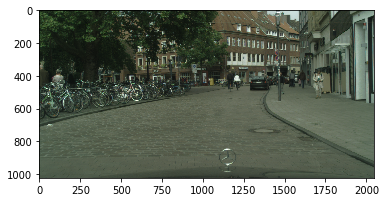

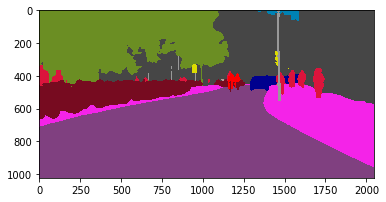

In [13]:
# For Evaluation and Visualizing the results

import os
import scipy.misc as m
import matplotlib.pyplot as plt



psp = pspnet(version="cityscapes")  #INSTANTIATING THE CITYSCAPES CLASS


#LOADING THE PRETRAINED MODEL WEIGHTS USING CAFFE MODEL
caffemodel_dir_path = "/ssd_scratch/cvit/amishra/"
psp.load_pretrained_model(model_path=os.path.join(caffemodel_dir_path, "pspnet101_cityscapes.caffemodel"))

psp.cuda()
psp.eval()



colors = [
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]


label_colours = dict(zip(range(19), colors))


#COLOR DEFINATION FOR DECODING THE PREDICTED MAP


def decode_segmap(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, 19):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
    return rgb

img = m.imread(os.path.join(dataset_root_dir,"leftImg8bit/val/munster/munster_000042_000019_leftImg8bit.png",))

orig_size = img.shape[:-1]

img1 = img.transpose(2, 0, 1)
img1 = img1.astype(np.float64)
img1 -= np.array([123.68, 116.779, 103.939])[:, None, None]
img1 = np.copy(img1[::-1, :, :])
img1 = torch.from_numpy(img1).float()  # convert to torch tensor
img1 = img1.unsqueeze(0)

out = psp.tile_predict(img1)
pred = np.argmax(out, axis=1)[0]
decoded = decode_segmap(pred)


# GETIING THE DECODED MAP FROM THE NETWORK (GROUND THRUTH AND THE SEG. MAP)


plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(decoded)